# Reconocedor de lengua de signos

Vamos a desarrollar una red que reconozca lengua de signos. Para ello, vamos a utilizar un dataset contenido en nuestra cuenta de Google Drive. Antes, debemos montar nuestro sistema de archivos de Google Drive para hacerlo accesible desde este *notebook*. Google nos solicitará permiso, tenemos que copiar y pegar el código que nos suministra.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

¿Estoy realmente utilizando una GPU? Compruébalo en **Editar / Configuración del cuaderno** o **Entorno de ejecución / Cambiar tipo de entorno de ejecución**

In [2]:
'''
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directorio principal que contiene los subdirectorios con imágenes
directorio_principal = './Descargas/ButterflyMoths/train/'  # Cambia esto a la ruta de tu directorio
directorio_principal = './datasets/ButterflyMoths/train/'  # Cambia esto a la ruta de tu directorio

# Obtener la lista de subdirectorios
subdirectorios = [d for d in os.listdir(directorio_principal) if os.path.isdir(os.path.join(directorio_principal, d))]

# Iterar a través de los subdirectorios y mostrar la primera imagen de cada uno
for subdirectorio in subdirectorios:
    # Obtener la lista de archivos en el subdirectorio
    archivos = os.listdir(os.path.join(directorio_principal, subdirectorio))

    # Encontrar la primera imagen en el subdirectorio
    primera_imagen = None
    for archivo in archivos:
        if archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            primera_imagen = archivo
            break

    # Mostrar la primera imagen si se encuentra
    if primera_imagen:
        ruta_imagen = os.path.join(directorio_principal, subdirectorio, primera_imagen)
        with Image.open(ruta_imagen) as img:
            plt.imshow(img)
            plt.title(f'Primera imagen en "{subdirectorio}"')
            plt.axis('off')
            plt.show()
    else:
        print(f"No se encontraron imágenes en el subdirectorio '{subdirectorio}'")
'''


'\nimport os\nfrom PIL import Image\nimport matplotlib.pyplot as plt\n\n# Directorio principal que contiene los subdirectorios con imágenes\ndirectorio_principal = \'./Descargas/ButterflyMoths/train/\'  # Cambia esto a la ruta de tu directorio\ndirectorio_principal = \'./datasets/ButterflyMoths/train/\'  # Cambia esto a la ruta de tu directorio\n\n# Obtener la lista de subdirectorios\nsubdirectorios = [d for d in os.listdir(directorio_principal) if os.path.isdir(os.path.join(directorio_principal, d))]\n\n# Iterar a través de los subdirectorios y mostrar la primera imagen de cada uno\nfor subdirectorio in subdirectorios:\n    # Obtener la lista de archivos en el subdirectorio\n    archivos = os.listdir(os.path.join(directorio_principal, subdirectorio))\n\n    # Encontrar la primera imagen en el subdirectorio\n    primera_imagen = None\n    for archivo in archivos:\n        if archivo.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\', \'.gif\', \'.bmp\')):\n            primera_imagen = arc

In [3]:
import tensorflow as tf

# Verifica si TensorFlow tiene acceso a la GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Keras/TensorFlow tiene acceso a la GPU -> {tf.test.gpu_device_name()}")
else:
    print("Keras/TensorFlow está utilizando la CPU.")


Keras/TensorFlow tiene acceso a la GPU -> /device:GPU:0


## Importaciones necesarias

In [4]:
# IMPORTS --------------------------------------------------
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import os

In [5]:
# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

### Data augmentation

In [6]:

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras_preprocessing.image import load_img, img_to_array

'''
image_size = (224, 224) 
batch_size = 16

# Configuración del generador de aumento de datos
data_augmentation = ImageDataGenerator(
    rescale=1./255,                 # Normalización de los valores de píxeles
    rotation_range=40,              # Grados de rotación aleatoria
    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,         # Desplazamiento vertical aleatorio
    shear_range=0.1,                # Cizalla aleatoria
    zoom_range=0.1,                 # Rango de zoom aleatorio
    channel_shift_range=5,         # Cambios aleatorios en los canales de colores
    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio
    horizontal_flip=True,           # Activar volteo horizontal
    vertical_flip=True,             # Activar volteo vertical
    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales
)

# Directorios de entrenamiento y validación
train_dir = './datasets/ButterflyMoths/train'
valid_dir = './datasets/ButterflyMoths/valid'

# Directorios de salida para las imágenes aumentadas
augmented_train_dir = './datasets/ButterflyMoths/augmented_train'
augmented_valid_dir = './datasets/ButterflyMoths/augmented_valid'

# Función para guardar las imágenes aumentadas
def save_augmented_images(directory, augmented_directory, generator, num_images_per_file=5):
    # Crear el directorio si no existe
    if not os.path.exists(augmented_directory):
        os.makedirs(augmented_directory)
    
    for subdir in os.listdir(directory):
        subdirectory = os.path.join(directory, subdir)
        if os.path.isdir(subdirectory):
            augmented_subdir = os.path.join(augmented_directory, subdir)
            if not os.path.exists(augmented_subdir):
                os.makedirs(augmented_subdir)
            
            for file in os.listdir(subdirectory):
                file_path = os.path.join(subdirectory, file)
                image_obj = load_img(file_path)
                image_array = img_to_array(image_obj)
                image_array = image_array.reshape((1,) + image_array.shape)
                
                # Generar nuevas imágenes
                i = 0
                for batch in generator.flow(image_array, batch_size=1, save_to_dir=augmented_subdir, save_prefix=subdir, save_format='jpeg'):
                    i += 1
                    if i >= num_images_per_file:
                        break  # Guardar 5 imágenes y luego continuar con la siguiente imagen

# Aplicar aumento de datos al conjunto de entrenamiento y validación
save_augmented_images(train_dir, augmented_train_dir, data_augmentation)
save_augmented_images(valid_dir, augmented_valid_dir, data_augmentation)


# Creación de los generadores
train_gen = data_augmentation.flow_from_directory(
    train_dir,
    target_size=image_size,  # Asegúrate de que coincida con el tamaño de entrada de tu modelo
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = data_augmentation.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
'''


"\nimage_size = (224, 224) \nbatch_size = 16\n\n# Configuración del generador de aumento de datos\ndata_augmentation = ImageDataGenerator(\n    rescale=1./255,                 # Normalización de los valores de píxeles\n    rotation_range=40,              # Grados de rotación aleatoria\n    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio\n    height_shift_range=0.1,         # Desplazamiento vertical aleatorio\n    shear_range=0.1,                # Cizalla aleatoria\n    zoom_range=0.1,                 # Rango de zoom aleatorio\n    channel_shift_range=5,         # Cambios aleatorios en los canales de colores\n    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio\n    horizontal_flip=True,           # Activar volteo horizontal\n    vertical_flip=True,             # Activar volteo vertical\n    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales\n)\n\n# Directorios de entrenamiento y validación\ntrain_dir = '

In [7]:
# DATA SOURCE --------------------------------------------------
# '''
image_size = (224, 224) 
batch_size = 16
data_dir = os.path.join('./datasets', 'fruit_classification', 'augmented_all')
train_dir = os.path.join('./datasets/ButterflyMoths/train') 
valid_dir = os.path.join('./datasets/ButterflyMoths/valid/') 
test_dir = os.path.join('./datasets/ButterflyMoths/test') 

train_dir = os.path.join('./datasets/ButterflyMoths/augmented_train/') 
valid_dir = os.path.join('./datasets/ButterflyMoths/augmented_valid/') 
test_dir = os.path.join('./datasets/ButterflyMoths/test') 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)


train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
# '''

Found 8098 files belonging to 8 classes.
Found 2287 files belonging to 8 classes.
Found 90 files belonging to 8 classes.


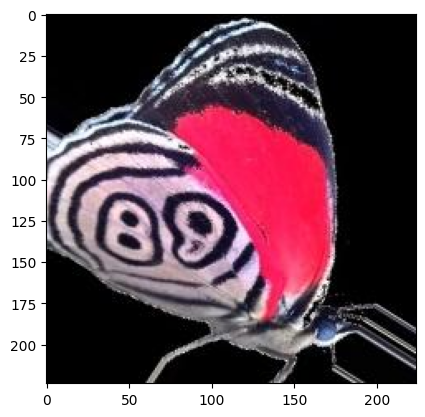

In [8]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

pil_im = Image.open('./datasets/ButterflyMoths/augmented_train/AN 88/AN 88_0_7.jpeg', 'r')
imshow(np.asarray(pil_im))


In [9]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()

model.add(Rescaling(scale=1./255.0,
                    offset=-1,
                    input_shape=(224,224,3)))


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])


In [10]:
# TRAINING --------------------------------------------------

epochs = 100

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds, # train_gen, 
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/100
507/507 [==============================] - 16s 21ms/step - loss: 0.9851 - accuracy: 0.6320 - val_loss: 0.3266 - val_accuracy: 0.8994
Epoch 2/100
507/507 [==============================] - 10s 20ms/step - loss: 0.2629 - accuracy: 0.9128 - val_loss: 0.2648 - val_accuracy: 0.9209
Epoch 3/100
507/507 [==============================] - 10s 20ms/step - loss: 0.1767 - accuracy: 0.9427 - val_loss: 0.2391 - val_accuracy: 0.9383
Epoch 4/100
507/507 [==============================] - 10s 20ms/step - loss: 0.1323 - accuracy: 0.9595 - val_loss: 0.1560 - val_accuracy: 0.9550
Epoch 5/100
507/507 [==============================] - 10s 20ms/step - loss: 0.1164 - accuracy: 0.9612 - val_loss: 0.2209 - val_accuracy: 0.9541
Epoch 6/100
507/507 [==============================] - 10s 20ms/step - loss: 0.0849 - accuracy: 0.9726 - val_loss: 0.1717 - val_accuracy: 0.9602
Epoch 7/100
507/507 [==============================] - 12s 23ms/step - loss: 0.0804 - accuracy: 0.9749 - val_loss: 0.1854 - val_ac

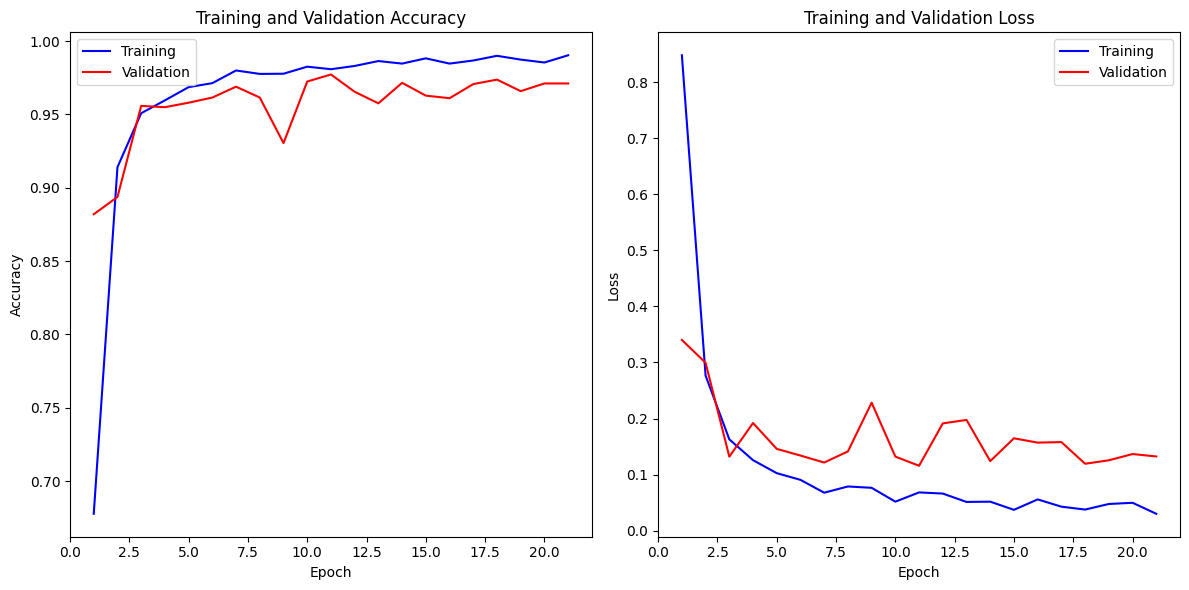

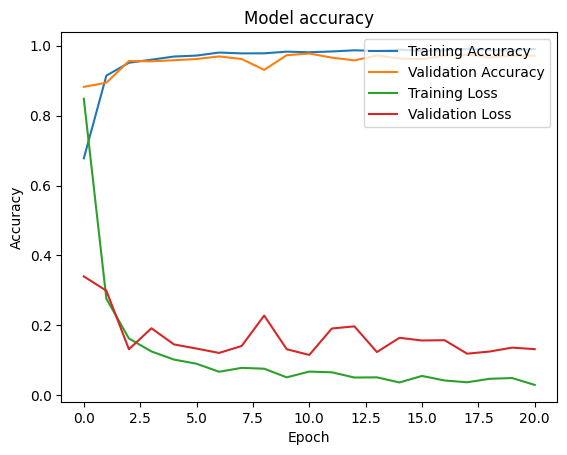

In [102]:
import matplotlib.pyplot as plt

def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

# Plots separados    
generatePlot(h)

# Plot conjunto
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy','Training Loss','Validation Loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

In [1]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#for x, y in val_ds:
#  print(len(y))


results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

# Crear un mapa de calor con etiquetas en los ejes
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print(classification_report(labels, predictions, digits = 4))

NameError: name 'val_ds' is not defined

In [ ]:
img = keras.preprocessing.image.load_img(
    './jellyfish/train/Aurelia_0023_jpg.rf.86edde0ccb85469a7108a278caa558fc.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))